<a href="https://colab.research.google.com/github/mrmm2703/first-cnn/blob/master/Natural%20Scenes%20Image%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the modules

These are the modules needed for this project:
*   `tensorflow`: For obvious reasons
*   `tensorflow.keras`: High level API for tensorflow
*   `numpy`: Mathematical functions and arrays
*   `matplotlib.pyplot`: Visualising data
*   `PIL.Image`: Image processing and manipulation
*   `os`: For accessing files in the directories

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Prepare the data

**NOTE: If loading an existing model from storage, skip to the [Import existing model](https://colab.research.google.com/drive/1LTDDaffpS_dkGPIht2Y0XtkHApV_PaM4#scrollTo=vrSbAEhZHcGn&line=1&uniqifier=1) after defining the `class_names` list and `root_drive_directory` string.**

## Import the dataset

Firstly, let's import the dataset from Google Drive.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Now let's define the locations for the images. There are several folders inside of folders, which is how the files are classified, which is why we're only going to be using the root directory rather than specifying every individual directory location.

In [ ]:
root_drive_directory = "C:\\Users\\mrahm\\Downloads\\images"

Let's define the different classes, which also happen to be the same names of the directories of the images within the respective classes.

In [ ]:
class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

Let's begin importing the data into our program by creating empty arrays for our datasets to live in.

**NOTE: Stop here in execution and skip to the [next section](https://colab.research.google.com/drive/1RRuIbvtd-QTrGz2HMCTbkPK_oq0RyVhU#scrollTo=JYjNm5ARDipd&line=1&uniqifier=1) to import the numpy arrays from storage rather than creating them from scratch.**

In [ ]:
train_images = np.zeros((14034, 150, 150, 3))
train_labels = np.zeros(14034)
test_images = np.zeros((3000, 150, 150, 3))
test_labels = np.zeros(3000)

Now that we have the locations of the datasets, we need to process the JPG images into our numpy arrays we defined earlier. We will us `PIL` for this. Let's create an iterative procedure for the testing images.

In [ ]:
i = 0
for class_name in class_names:
  directory = root_drive_directory + "/seg_test/" + class_name
  file_list = os.listdir(directory)
  for file_name in file_list:
    img = Image.open(directory + "/" + file_name)
    img_data = np.asarray(img)
    if img_data.shape != (150, 150, 3):
      img_data = np.asarray(img.resize((150, 150)))
    test_images[i] = img_data / 255.0
    test_labels[i] = int(class_names.index(class_name))
    i += 1

We iterate through all the directories defined in `class_names` and get a list of files inside each of them. Then we open image using `PIL.Image` and use `numpy.asarray` passing in the Pillow Image object as a parameter to get an array of pixel values. Then we store these into the images array and we store it into the labels array as a number which refers to the index of label inside `class_names`.

Then we go ahead and repeat the procedure for the training data too.

In [ ]:
i = 0
for class_name in class_names:
  directory = root_drive_directory + "/seg_train/" + class_name
  file_list = os.listdir(directory)
  for file_name in file_list:
    img = Image.open(directory + "/" + file_name)
    img_data = np.asarray(img)
    if img_data.shape != (150, 150, 3):
      img_data = np.asarray(img.resize((150, 150)))
    train_images[i] = img_data / 255.0
    train_labels[i] = class_names.index(class_name)
    i += 1

Now for future use, let's save these datesets into csv files.

In [ ]:
np.save(root_drive_directory + "/train_images", train_images)
np.save(root_drive_directory + "/train_labels", train_labels)
np.save(root_drive_directory + "/test_images", test_images)
np.save(root_drive_directory + "/test_labels", test_labels)

## Import the dataset (from stored numpy files)

Because of the limitations of processing all of the images one by one each time, we save the numpy arrays into Google Drive which we can directly create numpy arrays from, like so:

In [ ]:
train_images = np.load(root_drive_directory + "/train_images.npy")
train_labels = np.load(root_drive_directory + "/train_labels.npy")
test_images = np.load(root_drive_directory + "\\test_images.npy")
test_labels = np.load(root_drive_directory + "\\test_labels.npy")

## Preprocess the data

Now let's have a look at some of the images to make sure they were imported properly.

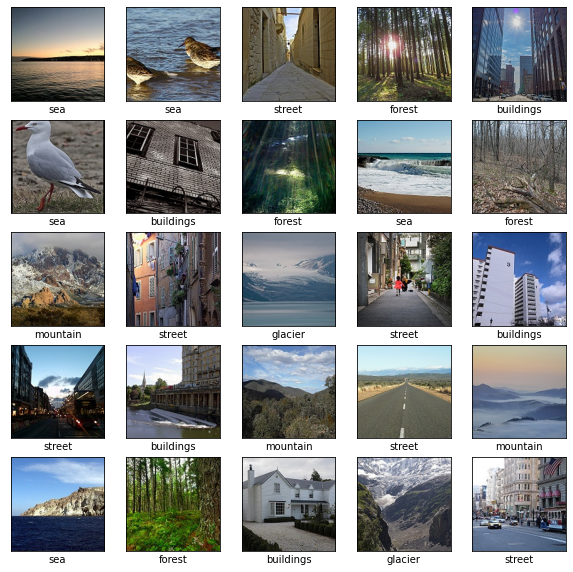

In [ ]:
plt.figure(figsize=(10,10))
i = 0
for x in np.random.randint(low=0, high=3000, size=25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[x])
  plt.xlabel(class_names[int(train_labels[x])])
  i += 1

# Building the model

## Setting up the layers

Unlike previous projects using basic 2D grayscale images, we're using RGB 2D images, so each pixel has three different values rather than just one value like the grayscale images did. Here, we're going to be using a convolutional neural network. We ues the following layers:
*   [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): This is a 2D convolution layer which can be used for spatial convolution over images.
*   [`MaxPooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): This is a max pooling operation for 2D spatial data. It downsamples the input representation by taking the maximum value defined in the pool_size parameter for each dimension along the features axis.
*   [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): The current output from the CNN is a 3D tensor, which the `Dense` layer will not work with. Therefore, we need to flatten the data from 3D to 1D so that the `Dense` layer can do its classifcation.
*   [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): This is a regular densely-connected neural network layer. This is the layer which performs the classification itself. It takes the last output tensor from the convolutional base into our Dense layers in this layer stack.

In [ ]:
model = keras.Sequential([
                          keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(150, 150, 3), padding="same"),
                          keras.layers.Conv2D(32, (3,3), activation="relu", strides=(2,2), padding="same"),
                          keras.layers.AveragePooling2D((2,2)),
                          keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
                          keras.layers.Conv2D(64, (3,3), activation="relu", strides=(2,2), padding="same"),
                          keras.layers.AveragePooling2D((2,2)),
                          keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
                          keras.layers.Conv2D(128, (3,3), activation="relu", strides=(2,2), padding="same"),
                          keras.layers.AveragePooling2D((2,2)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation="relu"),
                          keras.layers.Dense(6)

])

For this convolutional neural network, I created a layer stack as shown above. We start off with a `Conv2D` convolutional layer with a filters value of 32 and a kernel size of 3 by 3, this kernel size stays constant throughout the layer stack depending upon the `MaxPooling2D` to downsample the output from the convolutional layers through finding the maximum value in a 2x2 pool size. This then continues as the number of output filters increases with the `filters` argument. Then after all of the convolutional neural layers, we go add a flatten layer to flatten the data into a 1D array for the `Dense` layers. We use 2 `Dense` layers. The first is the actual classification layer and the second mentions the number of classes to classify the training data into. We also use padding to keep as much of the input data as possible as our neural layers decrease the spatial dimensions one by one. Using this combination of neural layers we can tell the model how to "scan" through the images using convolution. We don't mention stride to implicitly define it as 1 so that we can keep as much of the input data as possible again, and to make sure that the output volume layer isn't too low for the other layers to work on with their kernel sizes.

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
average_pooling2d_6 (Average (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 19, 19, 64)        36928     
_________________________________________________________________
average_pooling2d_7 (Average (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 9, 9, 128)        

Here we can see the summary of all the layers we created inside of our model. We can also see the output shape of each of neural layers.

## Compile the model

Now that we've gone through the process of defining the neural layers of our convolutional neural network, we can begin to compile the model to get it ready for training. For this, let's use the Adam algorithm optimiser and use the `SparseCategoricalCrossentropy` loss function to measure accuracy. We will use accuracy as a metric for this model.

In [ ]:
model.compile(optimizer="adam",
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

Now we've prepared the model ready for training. So let's get started on that next.

# Train the model

## Feed the model

First we fit the data. We'll use 10 epochs for this training session.

In [ ]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
439/439 [==============================] - 267s 609ms/step - loss: 1.0538 - accuracy: 0.5816
Epoch 2/10
439/439 [==============================] - 248s 565ms/step - loss: 0.7767 - accuracy: 0.6991
Epoch 3/10
439/439 [==============================] - 247s 562ms/step - loss: 0.6292 - accuracy: 0.7644
Epoch 4/10
439/439 [==============================] - 245s 558ms/step - loss: 0.5461 - accuracy: 0.7960
Epoch 5/10
439/439 [==============================] - 246s 561ms/step - loss: 0.4986 - accuracy: 0.8175
Epoch 6/10
439/439 [==============================] - 243s 554ms/step - loss: 0.4415 - accuracy: 0.8390
Epoch 7/10
439/439 [==============================] - 244s 556ms/step - loss: 0.4113 - accuracy: 0.8508
Epoch 8/10
439/439 [==============================] - 244s 555ms/step - loss: 0.3919 - accuracy: 0.8587
Epoch 9/10
439/439 [==============================] - 243s 554ms/step - loss: 0.3577 - accuracy: 0.8718
Epoch 10/10
439/439 [==============================] - 243s 554m

This model definetely took some time to build and train, so it would be nice to save the model. Let's do that.

In [ ]:
model.save(root_drive_directory + "/saved_model")

## Import existing model

Say we've got the model now, and we don't want to re-train the entire thing. Because we've saved the model, we can now open it right back up. Now we can get straight onto predicting data without loading up the individual images back into numpy arrays for training.

In [ ]:
model = keras.models.load_model(root_drive_directory + "\\saved_model")

## Evaluate accuracy

The model has now been trained after a lengthy amount of time! Let's test it out now and check it's accuracy using the `evaluate` function.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

94/94 - 17s - loss: 0.4263 - accuracy: 0.8477


As we can see, the model is overfitted by 4%, which isn't a huge margin, and I think quite a good accomplishment for my first own convolutional neural network with my own choice of layers.

## Make predictions

Now that we have our trained model loaded up (whether that be from storage or from training it), we can go ahead and make predictions now using some images. Let's begin by creating a probability model for the actual model itself using the `Softmax` function.

In [ ]:
probability_model = tf.keras.Sequential([
                                         model,
                                         tf.keras.layers.Softmax()
])

Now let's store all the predictions from the test_array inside of another list for us to have a look at.

In [ ]:
predictions = probability_model.predict(test_images)

## Verify predictions

Now that we have got the probabilities for each class loaded up into our array, let's look at visualising these results using `matplotlib.pylot`

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)
  
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label
  plt.grid(True)
  plt.xticks(range(6), rotation=90)
  plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
  thisplot = plt.bar(class_names, predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color("red")
  thisplot[int(true_label)].set_color("green")

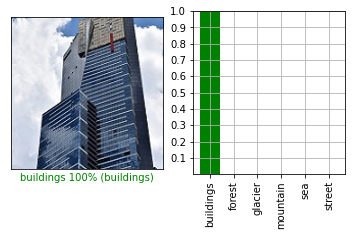

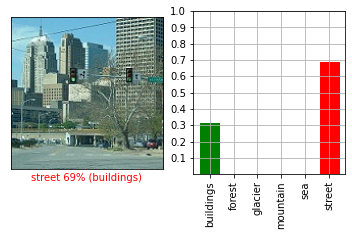

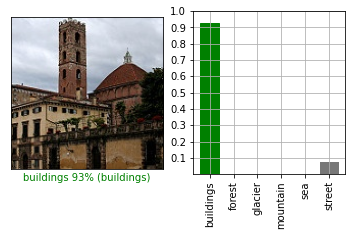

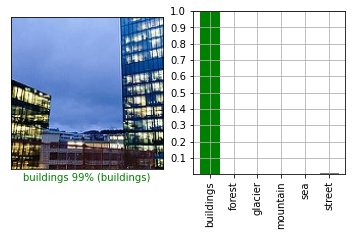

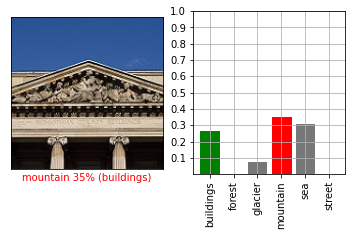

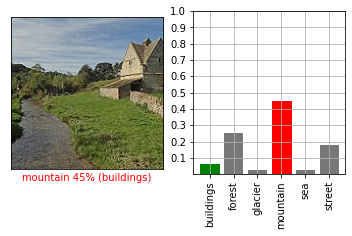

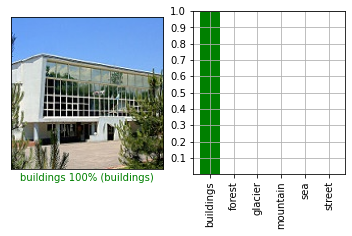

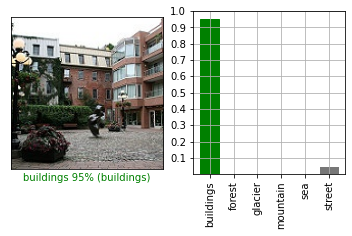

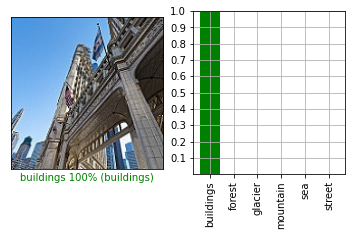

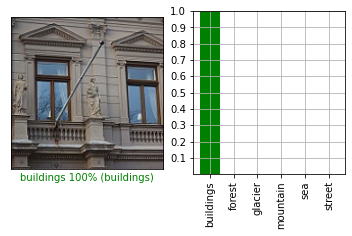

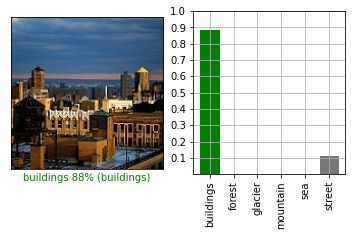

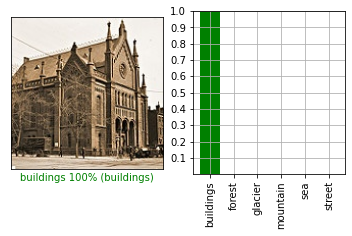

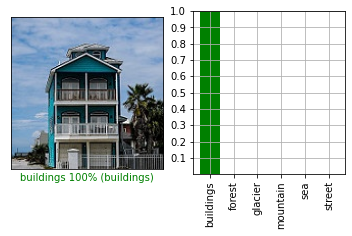

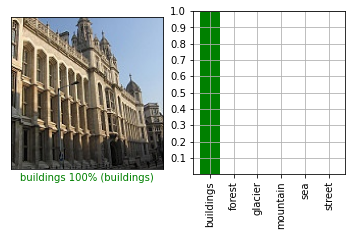

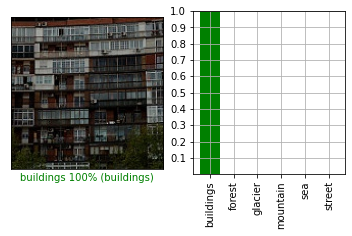

In [ ]:
i = 0
for i in range(15):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, predictions[i], test_labels[i], test_images[i])
  plt.subplot(1,2,2)
  plot_value_array(i, predictions[i], test_labels[i])
  plt.show()

# Use the model

Having the model is cool and all, but how can we implement it into something with a bit more user friendliness? Let's allow the user to specify an image, which we will then transform into a (150, 150, 3) numpy array for using our model to predict on.

Enter a file path to the image: C:\Users\mrahm\Downloads\ldeutc.jpg


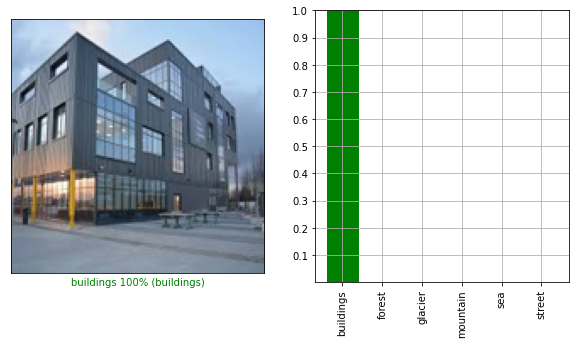

Enter a file path to the image: C:\Users\mrahm\Downloads\mountains.jpg


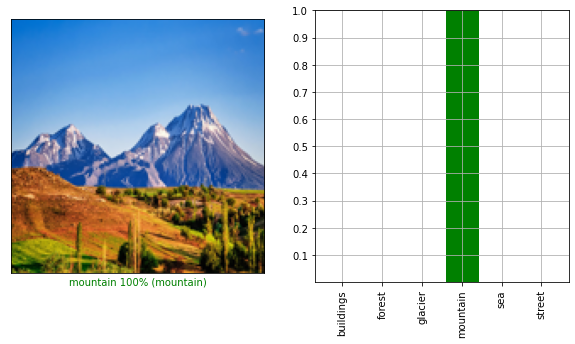

In [ ]:
file_path = input("Enter a file path to the image: ")
img_file = Image.open(file_path)
img_data = np.asarray(img_file)
if img_data.shape != (150, 150, 3):
  img_data = np.asarray(img_file.resize((150, 150)))
img = np.expand_dims(img_data, 0)
single_prediction = probability_model.predict(img)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_image(0, single_prediction[0], 0, img_data)
plt.subplot(1,2,2)
plot_value_array(0, single_prediction[0], 0)
plt.show()

file_path = input("Enter a file path to the image: ")
img_file = Image.open(file_path)
img_data = np.asarray(img_file)
if img_data.shape != (150, 150, 3):
  img_data = np.asarray(img_file.resize((150, 150)))
img = np.expand_dims(img_data, 0)
single_prediction = probability_model.predict(img)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_image(0, single_prediction[0], 3, img_data)
plt.subplot(1,2,2)
plot_value_array(0, single_prediction[0], 3)
plt.show()